In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import torch.nn.functional as F
import torch.nn as nn

In [10]:
# Load the DataFrame
df = pd.read_csv("./data.csv") # Make sure your data.csv is in the correct path

# --- Data Preparation ---
# 1. Clean the 'toponym' column: convert to string, strip whitespace, convert to lowercase
df['toponym'] = df['toponym'].astype(str).str.strip().str.lower()

# 2. Convert each toponym string into a list of tokens, adding <S> and <E>
#    Each character will be a separate token
#    We create a new column 'toponym_tokens' to store these lists
df['toponym_tokens'] = df['toponym'].apply(lambda x: ['<S>'] + list(x) + ['<E>'])

# Get all unique tokens from your processed data
all_tokens = []
for tokens_list in df['toponym_tokens']:
    all_tokens.extend(tokens_list)

# Create a sorted list of unique tokens (your vocabulary)
vocab = sorted(list(set(all_tokens)))

stoi = {token: i for i, token in enumerate(vocab)}

# Create mapping from integer to token (itos) for debugging/display
itos = {i: token for token, i in stoi.items()}

# Print the vocabulary size
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"stoi mapping: {stoi}")

Vocabulary size: 44
stoi mapping: {' ': 0, "'": 1, '-': 2, '<E>': 3, '<S>': 4, 'a': 5, 'b': 6, 'c': 7, 'd': 8, 'e': 9, 'f': 10, 'g': 11, 'h': 12, 'i': 13, 'j': 14, 'k': 15, 'l': 16, 'm': 17, 'n': 18, 'o': 19, 'p': 20, 'q': 21, 'r': 22, 's': 23, 't': 24, 'u': 25, 'v': 26, 'w': 27, 'x': 28, 'y': 29, 'z': 30, 'à': 31, 'â': 32, 'ç': 33, 'è': 34, 'é': 35, 'ê': 36, 'ë': 37, 'î': 38, 'ï': 39, 'ô': 40, 'û': 41, 'ü': 42, 'œ': 43}


In [11]:
# Define your context window size
block_size = 3 # Example: uses 3 previous characters to predict the next

# Initialize lists to store our input sequences (X) and target characters (Y)
X, Y = [], []

# Iterate through each preprocessed toponym (list of tokens)
for tokens_list in df['toponym_tokens']:
    # Pad the beginning of the context with the start-of-sequence token ID
    # This ensures every sequence has a full 'block_size' context, even at the start.
    context = [stoi['<S>']] * block_size

    # Iterate through each token in the current toponym, including <E>
    # The current 'token_id' will be our target (Y) for the current 'context' (X)
    for token_str in tokens_list:
        # Convert the current token to its integer ID
        token_id = stoi[token_str]

        # Add the current context (as a list of integers) to X
        X.append(context)

        # Add the current token's ID (which is the next character) to Y
        Y.append(token_id)

        # Update the context by sliding the window:
        # Remove the oldest character from the left and add the new character (token_id) to the right
        context = context[1:] + [token_id]

# Convert the Python lists to PyTorch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"\nShape of X (inputs): {X.shape}")
print(f"Shape of Y (targets): {Y.shape}")
print(f"Data type of X: {X.dtype}")
print(f"Data type of Y: {Y.dtype}")

# Example of the first few X and Y pairs
print("\nFirst 10 X, Y pairs:")
for i in range(20):
    context_chars = ''.join(itos[idx.item()] for idx in X[i])
    target_char = itos[Y[i].item()]
    print(f"Context: {context_chars} ---> Target: {target_char}")


Shape of X (inputs): torch.Size([98653, 3])
Shape of Y (targets): torch.Size([98653])
Data type of X: torch.int64
Data type of Y: torch.int64

First 10 X, Y pairs:
Context: <S><S><S> ---> Target: <S>
Context: <S><S><S> ---> Target: f
Context: <S><S>f ---> Target: r
Context: <S>fr ---> Target: a
Context: fra ---> Target: n
Context: ran ---> Target: c
Context: anc ---> Target: e
Context: nce ---> Target: <E>
Context: <S><S><S> ---> Target: <S>
Context: <S><S><S> ---> Target: f
Context: <S><S>f ---> Target: r
Context: <S>fr ---> Target: a
Context: fra ---> Target: n
Context: ran ---> Target: c
Context: anc ---> Target: e
Context: nce ---> Target:  
Context: ce  ---> Target: m
Context: e m ---> Target: é
Context:  mé ---> Target: t
Context: mét ---> Target: r


In [12]:
# Training split, dev/validation split, test split
# 80%, 10%, 10%

# Set a random seed for reproducibility in data splitting
random.seed(42) # Using random module for shuffling indices before splitting

# Create a permutation of indices
indices = list(range(X.shape[0]))
random.shuffle(indices)

n1 = int(0.8 * len(indices))
n2 = int(0.9 * len(indices))

Xtr, Ytr = X[indices[:n1]], Y[indices[:n1]]
Xdev, Ydev = X[indices[n1:n2]], Y[indices[n1:n2]]
Xte, Yte = X[indices[n2:]], Y[indices[n2:]]

print(f"\nXtr shape: {Xtr.shape}, Ytr shape: {Ytr.shape}")
print(f"Xdev shape: {Xdev.shape}, Ydev shape: {Ydev.shape}")
print(f"Xte shape: {Xte.shape}, Yte shape: {Yte.shape}")



Xtr shape: torch.Size([78922, 3]), Ytr shape: torch.Size([78922])
Xdev shape: torch.Size([9865, 3]), Ydev shape: torch.Size([9865])
Xte shape: torch.Size([9866, 3]), Yte shape: torch.Size([9866])


In [13]:
class CharLanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embd=64, n_hidden=256, block_size=3):
        super().__init__()
        self.block_size = block_size
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, n_embd)
        
        # Network architecture
        self.net = nn.Sequential(
            # Layer 1
            nn.Linear(n_embd * block_size, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            
            # Layer 2
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            
            # Layer 3
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            
            # Layer 4
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            
            # Layer 5
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            
            # Output layer
            nn.Linear(n_hidden, vocab_size)
        )
        
        # Initialize weights properly
        self._init_weights()
        
    def _init_weights(self):
        # Initialize embedding layer
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        
        # Initialize linear layers
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                if layer.weight.shape[0] == vocab_size:  # output layer
                    nn.init.normal_(layer.weight, mean=0.0, std=0.02)
                else:  # hidden layers
                    nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')  # Changed to relu
        
        # Initialize batch norm layers
        for layer in self.net:
            if isinstance(layer, nn.BatchNorm1d):
                nn.init.ones_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        # Embed the input tokens
        emb = self.embedding(x)  # shape: (batch_size, block_size, n_embd)
        
        # Flatten the embeddings for the linear layers
        x = emb.view(emb.shape[0], -1)  # shape: (batch_size, block_size * n_embd)
        
        # Forward pass through the network
        logits = self.net(x)  # shape: (batch_size, vocab_size)
        
        return logits

In [14]:
# Initialize the model
n_embd = 64  # embedding dimension
n_hidden = 256  # hidden layer dimension
model = CharLanguageModel(vocab_size, n_embd, n_hidden, block_size)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

CharLanguageModel(
  (embedding): Embedding(44, 64)
  (net): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=False)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=False)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=44, bias=True)
  )
)
Total par

In [15]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
batch_size = 64
max_steps = 100000
eval_interval = 1000

# Move data to device
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

# %%
# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

for step in range(max_steps):
    # Get a random batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters
    optimizer.step()
    
    # Track training loss
    train_losses.append(loss.item())
    
    # Evaluation
    if step % eval_interval == 0 or step == max_steps - 1:
        model.eval()
        with torch.no_grad():
            # Training loss
            train_logits = model(Xtr[:1000])
            train_loss = F.cross_entropy(train_logits, Ytr[:1000])
            
            # Validation loss
            val_logits = model(Xdev)
            val_loss = F.cross_entropy(val_logits, Ydev)
            val_losses.append(val_loss.item())
            
            # Update learning rate
            scheduler.step(val_loss)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pt')
        
        print(f"Step {step:6d}: Train loss {train_loss:.4f}, Val loss {val_loss:.4f}")
        model.train()

Step      0: Train loss 3.7764, Val loss 3.7762
Step   1000: Train loss 1.8054, Val loss 1.8895
Step   2000: Train loss 1.7728, Val loss 1.8290
Step   3000: Train loss 1.7311, Val loss 1.7920
Step   4000: Train loss 1.7454, Val loss 1.7822
Step   5000: Train loss 1.6727, Val loss 1.7595
Step   6000: Train loss 1.6632, Val loss 1.7470
Step   7000: Train loss 1.6714, Val loss 1.7437
Step   8000: Train loss 1.6483, Val loss 1.7317
Step   9000: Train loss 1.6284, Val loss 1.7232
Step  10000: Train loss 1.6039, Val loss 1.7161
Step  11000: Train loss 1.5727, Val loss 1.7102
Step  12000: Train loss 1.5777, Val loss 1.7075
Step  13000: Train loss 1.5839, Val loss 1.6949
Step  14000: Train loss 1.5790, Val loss 1.6993
Step  15000: Train loss 1.5675, Val loss 1.6872
Step  16000: Train loss 1.5766, Val loss 1.6883
Step  17000: Train loss 1.5540, Val loss 1.6947
Step  18000: Train loss 1.5611, Val loss 1.6887
Step  19000: Train loss 1.5343, Val loss 1.6795
Step  20000: Train loss 1.5651, Val loss

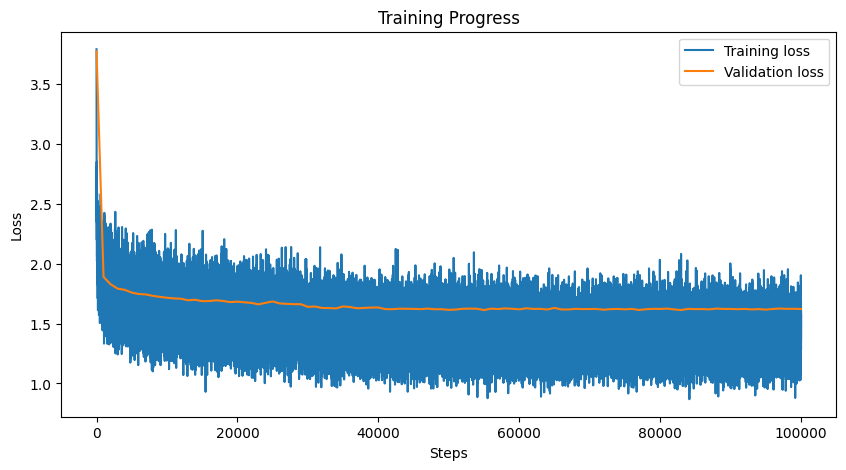

In [16]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(np.linspace(0, len(train_losses), len(val_losses)), val_losses, label='Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

In [ ]:
# Evaluate on test set
with torch.no_grad():
    test_logits = model(Xte)
    test_loss = F.cross_entropy(test_logits, Yte)
    print(f"Test loss: {test_loss:.4f}")

Test loss: 1.5914


In [18]:
# Sampling function
def generate_toponym(model, max_len=20, temperature=1.0):
    model.eval()
    with torch.no_grad():
        context = [stoi['<S>']] * block_size
        generated = []
        
        for _ in range(max_len):
            # Get logits
            x = torch.tensor([context], device=device)
            logits = model(x)
            
            # Apply temperature
            logits = logits / temperature
            
            # Get probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Sample from distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            
            # Update context and generated sequence
            context = context[1:] + [ix]
            generated.append(ix)
            
            # Stop if we generate end token
            if ix == stoi['<E>']:
                break
                
        # Convert to string
        return ''.join(itos[i] for i in generated if i != stoi['<S>'] and i != stoi['<E>'])

# Generate some examples
print("Generated toponyms:")
for _ in range(10):
    print(generate_toponym(model, temperature=0.7))

Generated toponyms:
départeme
bagne
saint-sur-mer
peyrat-sur-mer
saines
la champas-de-mar
saint-martement de
luy-de-bois-sur-sai
saint-martement
saint-martement des-
